# Introduction

In this notebook, I'm going to asses block and matrix size effects on performance of blocking-IJK matrix multiplication algorithm.

In this report I'm going to experiment with:

* Straightforward non-blocked ijk algorithm
* Blocked ijk algorithm using square b×b blocks based on BLAS calls
* Blocked kij algorithm using square b×b blocks based on ATLAS calls

Objectives of the experiment:

* Observe dependence of the execution time of each program on the matrix size n and block size b
* Observe speedup of the blocked algorithms over the non-blocked one as a function of the matrix size and the block size
* Compare the fastest program with ATLAS dgemm routine

In [3]:
%matplotlib inline
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from mpl_toolkits import mplot3d

# Test settings

To gather analyzable dataset, I'm going to double matrix size on every iteration. Also, to cover all the block sizes, I'm going to iteratively double number of blocks for every matrix size until block size reaches the size of 50.

In [4]:
sample_lists = []
min_block_size = 25
block_size_factor = 2
matrix_size_max = 6401
matrix_step_factor = 200
current_matrix_size = 200
while (current_matrix_size < matrix_size_max):
    current_block_size = current_matrix_size
    while(current_block_size >= min_block_size and current_block_size%block_size_factor == 0):
        sample_lists.append((current_matrix_size, int(current_block_size)))
        current_block_size = current_block_size/block_size_factor
    current_matrix_size = current_matrix_size*2
samples_table = np.asarray(sample_lists, dtype=np.int)

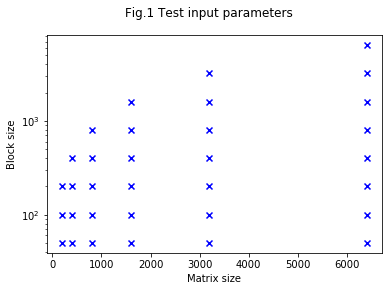

In [5]:
plt.scatter(samples_table[:,0], samples_table[:,1],c='b',marker='x')
plt.yscale('log')
plt.xlabel('Matrix size')
plt.ylabel('Block size')
plt.suptitle('Fig.1 Test input parameters')
plt.show()

To test the binaries on remote machine, this notebook is going to generate set of bash scripts for each binary:

In [6]:
# Plain IJK 
with open('.build/ijk.bash', 'w') as file:
    file.write("#!/bin/bash\n")
    for matrix_size in np.unique(samples_table[:,0]):
        file.write("./ijk" + " " + str(matrix_size) + "\n")
# Blocked ijk
with open('.build/blocked_ijk.bash', 'w') as file:
    for matrix_size, block_size in sample_lists:
        file.write("./blocked_ijk_blas" + " " + str(matrix_size) + " " + str(block_size) + "\n")
# Blocked kij
with open('.build/blocked_kij.bash', 'w') as file:
    for matrix_size, block_size in sample_lists:
        file.write("./blocked_kij_atlas" + " " + str(matrix_size) + " " + str(block_size) + "\n")

# Running tests and Importing data

For test purposes, I'm going to use linux machine with debian-unstable, hardware info:

* CPU Model: Intel(R) Xeon(R) CPU E5-2680 v2 @ 2.80GHz 16 cores
* Memory: 32GB RAM, Swap disabled

The bash scripts generated above are copied over to the target machine and executed there. Output files are copied back into .build directory.

In [7]:
ijk_times = np.loadtxt("ijk.csv", delimiter=";")
blocked_ijk_blas_times = np.loadtxt("blocked_ijk.csv", delimiter=";")
blocked_kij_atlas_times = np.loadtxt("blocked_kij.csv", delimiter=";")

To make these numbers comparable, I'm going to scale them according to the matrix sizes by dividing the time spent into matrix multiplication by roughly estimated complexity of the operation, which is matrix size taken to power 3:

$$ t_{adj} = \frac{t_{abs}}{m^3} $$

In [8]:
ijk_times_adj = np.copy(ijk_times)
ijk_times_adj[:,1] = ijk_times[:,1]/np.power(ijk_times[:,0],3)

blocked_ijk_blas_times_adj = np.copy(blocked_ijk_blas_times)
blocked_ijk_blas_times_adj[:,2] = blocked_ijk_blas_times[:,2]/np.power(blocked_ijk_blas_times[:,0],3)

blocked_kij_atlas_times_adj = np.copy(blocked_kij_atlas_times)
blocked_kij_atlas_times_adj[:,2] = blocked_kij_atlas_times[:,2]/np.power(blocked_kij_atlas_times[:,0],3)

To make the comparison fair for blocked algorithms, let's calculate min/max times:

In [9]:
# | 0. matrix_size | 1.min_time_block | 2.min_time | 3.max_time_block | 4.max_time |
def calculate_minmax(blocked_times):
    mx_sizes = np.unique(blocked_times[:,0])
    agg = dict.fromkeys(mx_sizes, np.empty([0,2],dtype=np.float64))        
    for i in blocked_times:
        if i[0] != i[1]:
            agg[i[0]] = np.append(agg[i[0]], [i[1:3]], axis=0)
    min_max = np.zeros((mx_sizes.size, 5),dtype=np.float64)
    min_max[:,0] = mx_sizes
    for row in min_max:
        row_table = agg[row[0]]
        min_idx = np.argmin(row_table[:,1])
        max_idx = np.argmax(row_table[:,1])
        row[1] = row_table[min_idx,0]
        row[2] = row_table[min_idx,1]
        row[3] = row_table[max_idx,0]
        row[4] = row_table[max_idx,1]
    return min_max

# Comparing non-blocked IJK with blocked BLAS/ATLAS 

First, let's plot the scaled (per-cell) times to estimate general difference:

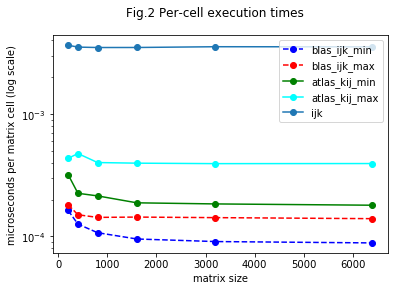

In [10]:
blocked_ijk_minmax = calculate_minmax(blocked_ijk_blas_times_adj)
blocked_kij_minmax = calculate_minmax(blocked_kij_atlas_times_adj)

plt.plot(blocked_ijk_minmax[:,0],blocked_ijk_minmax[:,2], color="blue", 
         linestyle='dashed', marker='o', label='blas_ijk_min')
plt.plot(blocked_ijk_minmax[:,0],blocked_ijk_minmax[:,4], color="red", 
         linestyle='dashed', marker='o', label='blas_ijk_max')
plt.plot(blocked_kij_minmax[:,0],blocked_kij_minmax[:,2], 
         color="green", marker='o', label='atlas_kij_min')
plt.plot(blocked_kij_minmax[:,0],blocked_kij_minmax[:,4], 
         color="cyan", marker='o', label='atlas_kij_max')
plt.plot(ijk_times_adj[:,0], ijk_times_adj[:,1], label='ijk', marker='o')
plt.yscale('log')
plt.xlabel('matrix size')
plt.ylabel('microseconds per matrix cell (log scale)')
plt.suptitle('Fig.2 Per-cell execution times')
plt.legend()
plt.show()

According to the graph below, non-blocked IJK algorithm performs about 10 times slower than slowest KIJ-blocked implementation based on ATLAS calls. To have an idea of how this impact total calculation, let's plot non-scaled times:

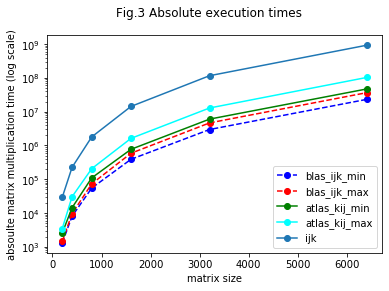

In [11]:
blocked_ijk_minmax_orig = calculate_minmax(blocked_ijk_blas_times)
blocked_kij_minmax_orig = calculate_minmax(blocked_kij_atlas_times)

plt.plot(blocked_ijk_minmax_orig[:,0],blocked_ijk_minmax_orig[:,2], color="blue", 
         linestyle='dashed', marker='o', label='blas_ijk_min')
plt.plot(blocked_ijk_minmax_orig[:,0],blocked_ijk_minmax_orig[:,4], color="red", 
         linestyle='dashed', marker='o', label='blas_ijk_max')
plt.plot(blocked_kij_minmax_orig[:,0],blocked_kij_minmax_orig[:,2], 
         color="green", marker='o', label='atlas_kij_min')
plt.plot(blocked_kij_minmax_orig[:,0],blocked_kij_minmax_orig[:,4], 
         color="cyan", marker='o', label='atlas_kij_max')
plt.plot(ijk_times[:,0], ijk_times[:,1], label='ijk', marker='o')
plt.yscale('log')
plt.xlabel('matrix size')
plt.ylabel('absoulte matrix multiplication time (log scale)')
plt.suptitle('Fig.3 Absolute execution times')
plt.legend()
plt.show()

According to the graph above, blocked algorithms show significant time improvement over non-blocked IJK implementation. Non-blocked algorithm shows very steep running time increase(this is log scale!) for small matrices(up to 2000x2000) compared to blocked solution.

# Matrix and block size effects on performance

First, let's plot scaled time per matrix size to have an idea of how different these values:

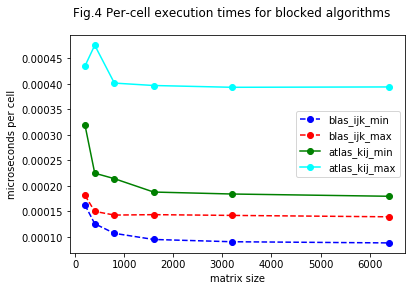

In [12]:
plt.plot(blocked_ijk_minmax[:,0],blocked_ijk_minmax[:,2], color="blue", 
         linestyle='dashed', marker='o', label='blas_ijk_min')
plt.plot(blocked_ijk_minmax[:,0],blocked_ijk_minmax[:,4], color="red", 
         linestyle='dashed', marker='o', label='blas_ijk_max')
plt.plot(blocked_kij_minmax[:,0],blocked_kij_minmax[:,2], 
         color="green", marker='o', label='atlas_kij_min')
plt.plot(blocked_kij_minmax[:,0],blocked_kij_minmax[:,4], 
         color="cyan", marker='o', label='atlas_kij_max')
plt.xlabel('matrix size')
plt.ylabel('microseconds per cell')
plt.suptitle('Fig.4 Per-cell execution times for blocked algorithms')
plt.legend()
plt.show()

As can be seen from the graph above, scaled time only changes for small matrices(less than 1000x1000) while remaining roughly the same for bigger matrices. This means that eventually, matrix size effect is equivalent to algorithm complexity $O(n^3)$.

Since the time values are scaled and are not affected by matrix size, we can compare average times for blocked algorithms against data gathered from non-blocked runs.

In [13]:
def block_size_times(blocked_times):
    block_size_map = dict.fromkeys(np.unique(blocked_times[:,1]), np.empty(0,dtype=np.float64))
    for i in blocked_times:
        if i[0] != i[1]:
            block_size_map[i[1]] = np.append(block_size_map[i[1]], [i[2]], axis=0)
    block_size_data = np.empty((0,2),dtype=np.float64)
    for key,val in block_size_map.items():
        if val.size >= 2: # There must be at least 2 datapoints
            block_size_data = np.append(block_size_data, [[key, np.average(val)]], axis=0)
    return block_size_data

ijk_block_size_avg_times = block_size_times(blocked_ijk_blas_times_adj)
kij_block_size_avg_times = block_size_times(blocked_kij_atlas_times_adj)


Now let's find timings for blas/atlas calls by only selecting the data points, where size of the matrix is equal to the size of the block:

In [14]:
def non_blocked_times(blocked_times):
    times_data = np.empty((0,2),dtype=np.float64)
    for i in blocked_times:
        if i[0] == i[1]:
            times_data = np.append(times_data, [[i[0], i[2]]], axis=0)
    return times_data
blas_no_block_times = non_blocked_times(blocked_ijk_blas_times_adj)
atlas_no_block_times = non_blocked_times(blocked_kij_atlas_times_adj)

Now, let's plot avg time for blocked algorithms together with non-blocked atlas/blas data:

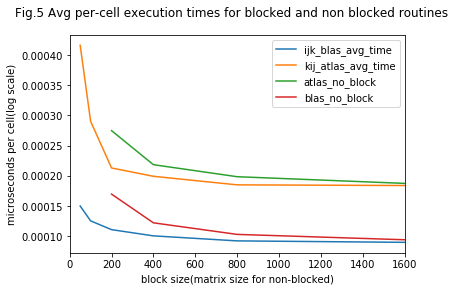

In [15]:
plt.plot(ijk_block_size_avg_times[:,0],ijk_block_size_avg_times[:,1], label="ijk_blas_avg_time")
plt.plot(kij_block_size_avg_times[:,0],kij_block_size_avg_times[:,1], label="kij_atlas_avg_time")
plt.plot(atlas_no_block_times[:,0],atlas_no_block_times[:,1], label="atlas_no_block")
plt.plot(blas_no_block_times[:,0],blas_no_block_times[:,1], label="blas_no_block")
plt.xlim(left=0, right=np.amax(ijk_block_size_avg_times[:,0]))
plt.xlabel('block size(matrix size for non-blocked)')
plt.ylabel('microseconds per cell(log scale)')
plt.suptitle('Fig.5 Avg per-cell execution times for blocked and non blocked routines')
plt.legend()
plt.show()

As cab be see from the plot, the difference between blocking and non-blocking algorithms decreases with an increase in matrix/block size. 

# Conclusions

## Dependence of the execution time of each program on the matrix size n and the block size b

According to Fig.4, matrix size does not have an impact on relative algorithm execution time. No matter how big the matrices are, the effect on absolute execution time is equivalent to the algorithm complexity $O(n^3)$.

As shown at Fig.5 block size does have an impact on relative algorithm execution time. In this particular experiment, time spent per cell significantly improves with block size increase from 50 to 800, while staying mostly flat from 800 to 3200. This can be explained with ATLAS/BLAS routines being slow on small matrices due to their overhead.

## Speedup of the blocked algorithms over the non-blocked algorithms

For algorithms based BLAS/ATLAS routines, performance difference decreases with increasing block sizes. According to Fig.5, this difference is ~5 microsecond for block size of 200 and less than ~1 microsecond with block size of 1600.

This decrease can be explained with hitting limits in CPU cache size. Considering "double" type taking 8 bytes of memory, total memory use for the block size of 800, total theoretical memory needed per 1 block(for 3 matrices) is $3\cdot{\frac{(800^2)\cdot{8}}{10^3}}=15.36$ megabytes which fits in 30MB cache of Xeon(R) CPU E5-2680 CPU. While the same number for the block size of 1600 is $3\cdot{\frac{(1600^2)\cdot{8}}{10^3}}=61.44$ megabytes, which reduces an effect from blocking, causing cache misses in BLAS routine.

However, according to Fig.2, the difference is dramatic when comparing to straightforward IJK algorithm, being about $10^2$ times slower than the worst run of BLAS-based implementations and about 10 times slower than the worst run of ATLAS-based implementation.

## Comparison between ATLAS routine and the fastest implementation

According to the microseconds per cell to matrix size plot in Fig.2, fastest implementation is the BLAS-based IJK-blocked program. According to comparison to atlas routine on Fig.5, in this particular experiment, ATLAS routine was ~10 microseconds per cell slower than average run of BLAS-based IJK-blocked algorithm. However, this difference is mainly caused by BLAS routines being faster than ATLAS routines.